In [10]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
import nltk
from nltk.tokenize import word_tokenize, MWETokenizer

# cleared warnings
import warnings
warnings.filterwarnings('ignore')

# Only need to run once
# nltk.download('punkt')

## Import Data from CSV

In [11]:
data_url = "gsearch_jobs.csv"
jobs_all = pd.read_csv(data_url).replace("'","", regex=True)
jobs_all.date_time = pd.to_datetime(jobs_all.date_time) # convert to date time
jobs_all = jobs_all.drop(labels=['Unnamed: 0', 'index'], axis=1, errors='ignore')
jobs_all.description_tokens = jobs_all.description_tokens.str.strip("[]").str.split(",")

## Data Integrity Check

In [12]:
print("Big Query Statistics:")
print("---------------------")
print(f"Rows of data: {len(jobs_all)}")

repeat_jobs = jobs_all.job_id.value_counts()
try:
    repeat_jobs = repeat_jobs[repeat_jobs>1].index[0]
    repeat_jobs = len(repeat_jobs)
except IndexError:
    repeat_jobs = "None"
print(f"Number jobs repeated: {repeat_jobs}")

first_date = jobs_all.date_time.dt.date.min()
today_date = datetime.date.today() #+ datetime.timedelta(days=2) # test function works
date_count = pd.DataFrame(jobs_all.date_time.dt.date.value_counts())
missing_dates = list(pd.date_range(start=first_date, end=today_date).difference(date_count.index))
if len(missing_dates) > 0:
    print("Missing data for following dates:")
    for date in missing_dates:
        print(date)
else:
    print(f"No missing dates of data since inception of: {first_date}")

delta_days = (today_date - (first_date - datetime.timedelta(days=2))).days # first day was actually day prior but UTC
jobs_day = round(len(jobs_all)/delta_days)
print(f"Average number of jobs per day: {jobs_day}")
print(f"Collecting data for {delta_days} days now...")

Big Query Statistics:
---------------------
Rows of data: 1820
Number jobs repeated: None
Missing data for following dates:
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-03 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00
2022-12-10 00:00:00
2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-17 00:00:00
2022-12-18 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00
2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00
2022-12-31 00:00:00
2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00

## Exploratory Data Analysis

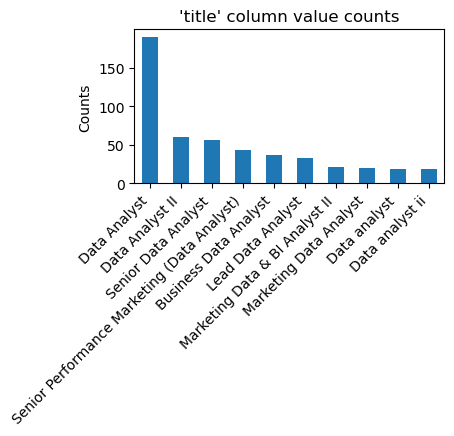

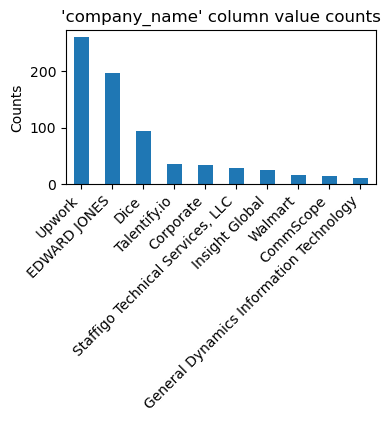

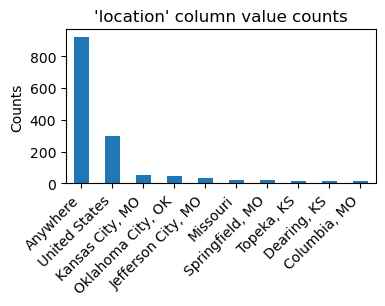

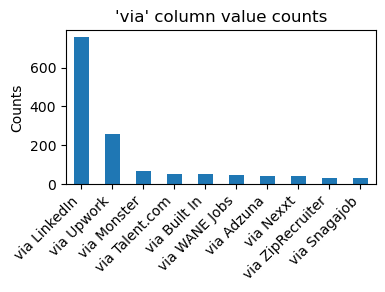

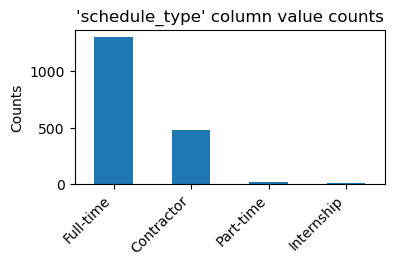

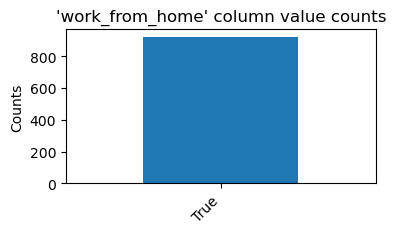

In [13]:
def eda_plot(column, topn=10):
    plt.figure(figsize=(4, 2))
    jobs_all[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 45, ha='right')
    plt.show()

columns = ['title', 'company_name', 'location', 'via', 'schedule_type', 'work_from_home']

for column in columns:
    eda_plot(column)

## Data Cleaning

### Salary Cleaning

In [14]:
# Separate 'salary' column into that for min max avg and rate (e.g., hourly)
jobs_all[['salary_pay', 'salary_rate']] = jobs_all.salary.str.split(' ', 1, expand=True)
jobs_all.salary_pay = jobs_all.salary_pay.str.replace(',', '').str.replace('$', '').str.replace(' ', '')
jobs_all['salary_avg'] = np.where(jobs_all.salary_pay.str.contains("–"), np.NaN, jobs_all.salary_pay)  # The character U+2013 "–" could be confused with the character U+002d "-", which is more common in source code. Adjust settings
jobs_all['salary_min'] = np.where(jobs_all.salary_pay.str.contains("–"), jobs_all.salary_pay, np.NaN)
jobs_all[['salary_min', 'salary_max']] = jobs_all.salary_min.str.split("–", 1, expand=True)
for column in ['salary_avg', 'salary_min', 'salary_max']:
    jobs_all[column] = np.where(jobs_all[column].str.contains("K"), jobs_all[column].str.replace("K", "").astype(float) * 1000 , jobs_all[column] ) # factor in K as 1000x
jobs_all['salary_avg'] = np.where(~jobs_all.salary_min.isnull(), (jobs_all.salary_min.astype(float) + jobs_all.salary_max.astype(float))/2 , jobs_all.salary_avg)
jobs_all['salary_hourly'] = np.where(jobs_all.salary_rate == 'an hour', jobs_all.salary_avg.astype(float), np.NaN)
jobs_all['salary_yearly'] = np.where(jobs_all.salary_rate == 'a year', jobs_all.salary_avg.astype(float), np.NaN)

# Standardize salary to all be annual
jobs_all['salary_standardized'] = np.NaN
salary_rate = {'a year': 1, 'an hour': 2080, 'a month': 12}
for key, index in salary_rate.items():
    jobs_all.salary_standardized = np.where(jobs_all.salary_rate == key, jobs_all.salary_avg.astype(float) * index, jobs_all.salary_standardized)

# Used to check results as built above
salary_df = jobs_all[~jobs_all.salary.isnull()]
salary_df = salary_df[['company_name', 'salary', 'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max', 'salary_standardized', 'salary_hourly', 'salary_yearly']] #, 'salary_min', 'salary_max']
pd.set_option('display.max_rows', salary_df.shape[0]+1)
salary_df.head(10)

,company_name,salary,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_standardized,salary_hourly,salary_yearly
1,Harnham,60–70 an hour,60–70,an hour,65.0,60,70,135200.000,65.0,NaN
4,Cyber Resource,"68,694.19–133,665.00 a year",68694.19–133665.00,a year,101179.595,68694.19,133665.00,101179.595,NaN,101179.595
10,United States Steel,20 an hour,20,an hour,20,NaN,None,41600.000,20.0,NaN
12,Elite Insurance Partners,60K a year,60K,a year,60000.0,NaN,None,60000.000,NaN,60000.000
16,Consultis,45–50 an hour,45–50,an hour,47.5,45,50,98800.000,47.5,NaN
23,CommScope,67K–83.7K a year,67K–83.7K,a year,75350.0,67000.0,83700.0,75350.000,NaN,75350.000
25,CommScope,67K–83.7K a year,67K–83.7K,a year,75350.0,67000.0,83700.0,75350.000,NaN,75350.000
31,1 point system,55–60 an hour,55–60,an hour,57.5,55,60,119600.000,57.5,NaN
32,Precision Technology,"47,546.74–110,472.90 a year",47546.74–110472.90,a year,79009.82,47546.74,110472.90,79009.820,NaN,79009.820
35,DevCare solutions,47–55 an hour,47–55,an hour,51.0,47,55,106080.000,51.0,NaN


Text(0.5, 0, '($USD/hr) Hourly Pay')

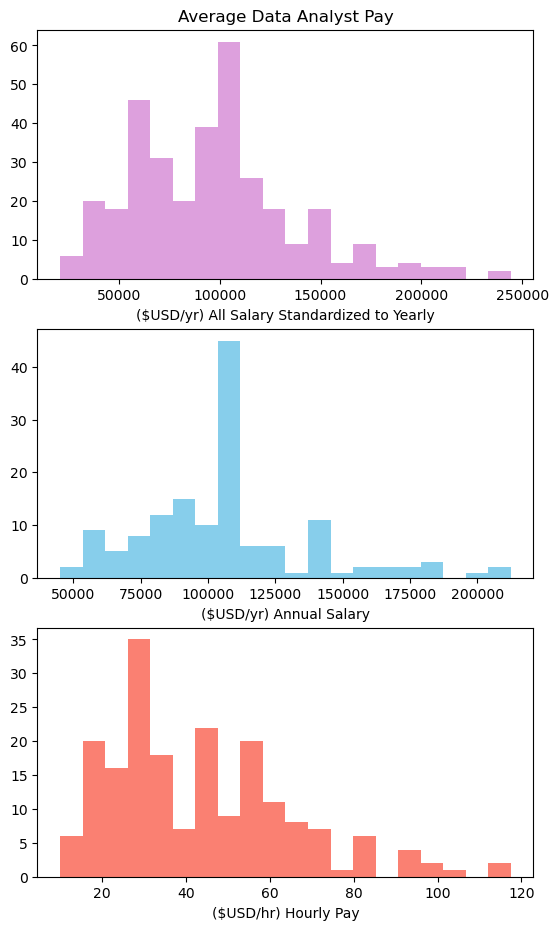

In [15]:
# Graph the spread of rate of pay per salary_rate
# plt.figure(figsize=(10, 2))
fig, axs = plt.subplots(3)
fig.set_figheight(11)
axs[0].hist(jobs_all.salary_standardized, bins = 20, color = 'plum')
axs[0].set_title("Average Data Analyst Pay")
axs[0].set_xlabel("($USD/yr) All Salary Standardized to Yearly")
axs[1].hist(jobs_all.salary_yearly, bins = 20, color = 'skyblue')
axs[1].set_xlabel("($USD/yr) Annual Salary")
axs[2].hist(jobs_all.salary_hourly, bins = 20, color = 'salmon')
axs[2].set_xlabel("($USD/hr) Hourly Pay")

### Description Cleaning - Languages and Tools

In [19]:
# Picked out keywords based on all keywords (only looked at words with 100+ occurrences)
keywords_programming = [
'sql', 'python', 'r', 'c', 'c#', 'javascript', 'js',  'java', 'scala', 'sas', 'matlab', 
'c++', 'c/c++', 'perl', 'go', 'typescript', 'bash', 'html', 'css', 'php', 'powershell', 'rust', 
'kotlin', 'ruby',  'dart', 'assembly', 'swift', 'vba', 'lua', 'groovy', 'delphi', 'objective-c', 
'haskell', 'elixir', 'julia', 'clojure', 'solidity', 'lisp', 'f#', 'fortran', 'erlang', 'apl', 
'cobol', 'ocaml', 'crystal', 'javascript/typescript', 'golang', 'nosql', 'mongodb', 't-sql', 'no-sql',
'visual_basic', 'pascal', 'mongo', 'pl/sql',  'sass', 'vb.net', 'mssql', 
]

keywords_libraries = [
'scikit-learn', 'jupyter', 'theano', 'openCV', 'spark', 'nltk', 'mlpack', 'chainer', 'fann', 'shogun', 
'dlib', 'mxnet', 'node.js', 'vue', 'vue.js', 'keras', 'ember.js', 'jse/jee',
]

keywords_analyst_tools = [
'excel', 'tableau',  'word', 'powerpoint', 'looker', 'powerbi', 'outlook', 'azure', 'jira', 'twilio',  'snowflake', 
'shell', 'linux', 'sas', 'sharepoint', 'mysql', 'visio', 'git', 'mssql', 'powerpoints', 'postgresql', 'spreadsheets',
'seaborn', 'pandas', 'gdpr', 'spreadsheet', 'alteryx', 'github', 'postgres', 'ssis', 'numpy', 'power_bi', 'spss', 'ssrs', 
'microstrategy',  'cognos', 'dax', 'matplotlib', 'dplyr', 'tidyr', 'ggplot2', 'plotly', 'esquisse', 'rshiny', 'mlr',
'docker', 'linux', 'jira',  'hadoop', 'airflow', 'redis', 'graphql', 'sap', 'tensorflow', 'node', 'asp.net', 'unix',
'jquery', 'pyspark', 'pytorch', 'gitlab', 'selenium', 'splunk', 'bitbucket', 'qlik', 'terminal', 'atlassian', 'unix/linux',
'linux/unix', 'ubuntu', 'nuix', 'datarobot',
]

keywords_cloud_tools = [
'aws', 'azure', 'gcp', 'snowflake', 'redshift', 'bigquery', 'aurora',
]

keywords = keywords_programming + keywords_libraries + keywords_analyst_tools + keywords_cloud_tools 

jobs_all = jobs_all[jobs_all.description.notnull()] # filter out null values
jobs_all = jobs_all.reset_index() # throwing index issues if don't reset index
# jobs_all = jobs_all.head(10) 

# now we add a column that contains the key words found in the job's description
jobs_all['description_tokens'] = ""
for index, row in jobs_all.iterrows():
    # lowercase words
    detail = row.description.lower()
    # tokenize words
    detail = word_tokenize(detail)
    # handle multi-word tokenization (e.g., 'Power BI')
    multi_tokens = [('power', 'bi'), ('data', 'lake'), ('data', 'lakes'), ('machine', 'learning'), ('objective', 'c'),
                    ('visual', 'basic')]
    tokenizer = MWETokenizer(multi_tokens)
    detail = tokenizer.tokenize(detail)
    # remove duplicates
    detail = list(set(detail))
    # filter for keywords only
    detail = [word for word in detail if word in keywords] 
    # replace duplicate keywords
    replace_tokens = {'powerbi' : 'power_bi', 'spreadsheets': 'spreadsheet'}
    for key, value in replace_tokens.items():
        detail = [d.replace(key, value) for d in detail]
    # add to details list # row.description_tokens = detail
    jobs_all.at[index, 'description_tokens'] = detail

### More EDA of Top Skills

In [17]:
def filtered_keywords(jobs_filtered, keywords, title="Keyword Analysis", head=10):
    # get keywords in a column
    count_keywords = pd.DataFrame(jobs_filtered.description_tokens.sum()).value_counts().rename_axis('keywords').reset_index(name='counts')

    # get frequency of occurence of word (as word only appears once per line)
    length = len(jobs_filtered) # number of job postings
    count_keywords['percentage'] = 100 * count_keywords.counts / length

    # plot the results
    count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
    count_keywords = count_keywords.head(head)
    g = plt.bar(x="keywords", height="percentage", data=count_keywords , color=np.random.rand(len(count_keywords.keywords), 3))
    plt.xlabel("")
    plt.ylabel("Likelyhood to be in job posting (%)")
    plt.xticks(rotation = 45, ha='right')
    plt.title(title) 
    plt.show(g)
    print(count_keywords)

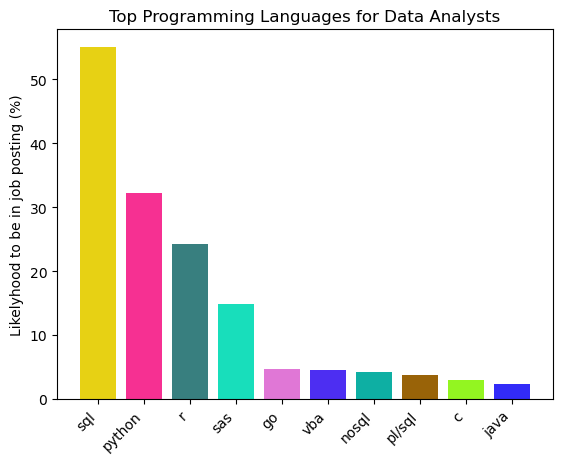

   keywords  counts  percentage
0       sql    1002   55.054945
2    python     587   32.252747
5         r     442   24.285714
6       sas     270   14.835165
15       go      84    4.615385
16      vba      82    4.505495
17    nosql      78    4.285714
20   pl/sql      68    3.736264
22        c      53    2.912088
24     java      42    2.307692


In [18]:
filtered_keywords(jobs_all, keywords_programming, title="Top Programming Languages for Data Analysts")

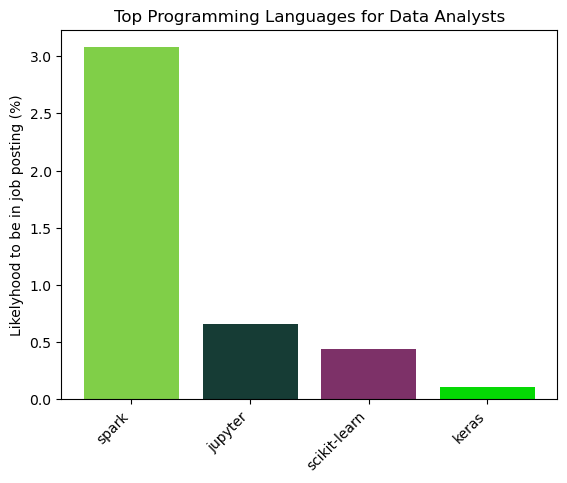

        keywords  counts  percentage
21         spark      56    3.076923
55       jupyter      12    0.659341
61  scikit-learn       8    0.439560
87         keras       2    0.109890


In [20]:
filtered_keywords(jobs_all, keywords_libraries, title="Top Programming Languages for Data Analysts")

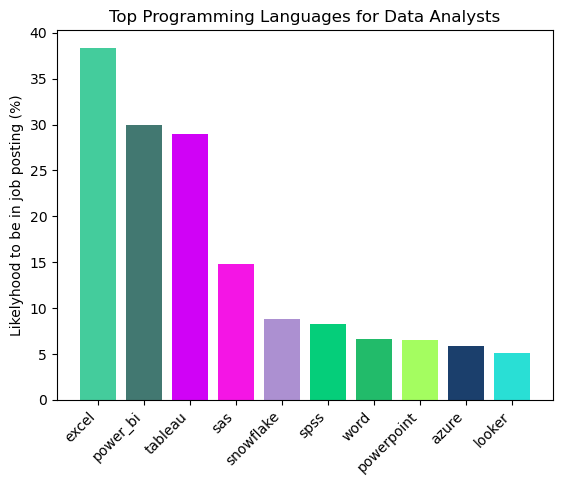

      keywords  counts  percentage
1        excel     698   38.351648
3     power_bi     546   30.000000
4      tableau     528   29.010989
6          sas     270   14.835165
7    snowflake     161    8.846154
8         spss     150    8.241758
9         word     120    6.593407
10  powerpoint     119    6.538462
12       azure     107    5.879121
13      looker      93    5.109890


In [21]:
filtered_keywords(jobs_all, keywords_analyst_tools, title="Top Programming Languages for Data Analysts")

 Finally we see our end results and we split it into three parts: languages, libraries, and analyst tools. For languages, we see that SQL and Python are the most sought out for languages in job listings. Spark is very popular among employers for libraries and Excel, Power BI, and Tableau are the three most sought out for tools jobs look for in data analyst.